In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
import math
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [4]:
#import data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']

In [5]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5

aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim1_onsets = stim_onsets[stim_type==2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim2.append(aligned_spikes)
    

In [6]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5


aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

In [7]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [8]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


# Exercise 2

## A.

\begin{equation}
I = \sum_x \lambda (x) \log_2 \frac{\lambda (x) + \epsilon}{\lambda} p_{occ}(x)
\end{equation}

\begin{equation}
I_s = I / \lambda
\end{equation}
Second equation is prefered for low firing rates, as is the case with place cells. First equation is in bits/second, and the second equation in bits/spike.

In [9]:
epsilon = 10**(-15)
lamb = np.mean(firing_rate_maps, axis=1) # average firing rate
lamb_x = firing_rate_maps #firing rate
p_occ = occupancy/np.sum(occupancy)#occupancy probability

In [10]:
I = np.zeros(100)
for i in range(len(lamb_x[1])):
    I[:] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
    
I_s = I/lamb

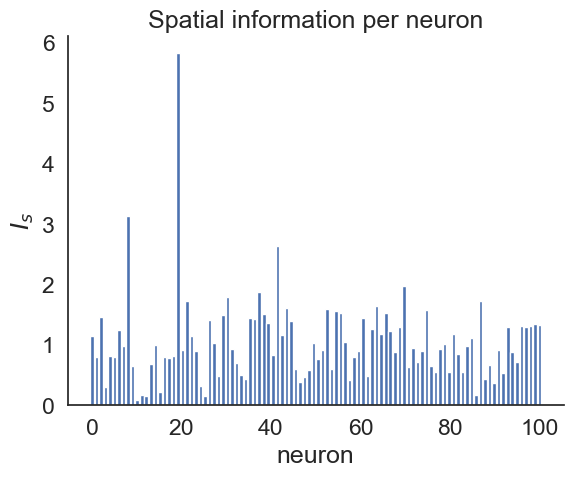

In [11]:
plt.bar(np.linspace(0,100,100), I_s)
plt.xlabel('neuron')
plt.ylabel(r'$I_s$')
plt.title('Spatial information per neuron')
plt.show()

## B.

Vary the peak firing rate over 0.1, 0.5, and 1?